#HAR_model_eval_stratification.ipynb
Loads the X,y,sub numpy arrays generated by dataset specific get_X_y_sub.ipynb  
Performs stratification twice.
train/test in a 80/20 split, then 25% of train into validate, so 60/20/20  
Builds and evaluates a 1D model.  
Records validation accuracy and test accuracy to log file.  

Tested with MobiACT, UniMiB, e4_Nov2019 datasets

IMPORTANT:  Since the model geometry is data set dependent, you must rebuild the model after selecting a different data set.


<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.

Lee B. Hinkle, Texas State University, [IMICS Lab](https://imics.wp.txstate.edu/)  

TODO:  
* Resolve WARNING:tensorflow:Please add `keras.layers.InputLayer` instead of `keras.Input` to Sequential model.
* Update/fix the visualization and confusion matrix code at end
* Improve formatting of the validation and pred accuracy - should be headers and comma separated with the average also calculated.
* Automatically handle the target_labels needed for the evaluations and confusion matrix.

#Imports

In [1]:
import os
import sys
import shutil #https://docs.python.org/3/library/shutil.html
from shutil import unpack_archive # to unzip
#from shutil import make_archive # to create zip for storage
import requests #for downloading zip file
import glob # to generate lists of files in directory - unix style pathnames
#from scipy import io #for loadmat, matlab conversion
import pandas as pd
import numpy as np
#import matplotlib.pyplot as plt # for plotting - pandas uses matplotlib
from tabulate import tabulate # for verbose tables
import matplotlib.pyplot as plt # for plotting training curves
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupKFold
from tensorflow import keras #added to save model
from tensorflow.keras import layers #format matches MNIST example
import tensorflow as tf #access utils - imports probably need to be cleaned up
# to measure and display training time
import time
from datetime import timedelta

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
#imports for computing and displaying output metrics
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support


In [2]:
#Helpful functions especially inside colab
from requests import get
def what_is_my_name():
    """returns the name of the running colab ipynb file"""
    #code is readily available on web - not original
    if 'google.colab' in str(get_ipython()):
        my_name = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']
        my_name += ".ipynb"
    else:
        # seems a bit complicated to get filename in any environment
        # and hard coding the name here will make this not portable
        # this should elminate the failure in non-colab instances though
        my_name = 'Executing local file, not running in CoLab'
    return my_name
#start output file with unique name - important for colab runs
def start_logfiles(base_name = "unnamed", first_line = "nothing here"):
    """creates file and writes colab environment info, returns full filename
    which is concatenation of path, base_name, and current UTC time"""
    result_dir = '/content/drive/My Drive/Colab_Run_Results'
    timestamp = time.strftime('%b-%d-%Y_%H%M', time.localtime()) #UTC time
    log_fname = base_name +'_'+timestamp
    full_log_fname = result_dir+'/'+log_fname+'.txt'
    print("Starting text logfile ",full_log_fname)
    with open(full_log_fname, "w") as file_object:
        header = first_line + '\n'
        header += full_log_fname +'\n'
        header += 'Generated by ' + what_is_my_name() + '\n'
        cpu_model = !grep 'model name' /proc/cpuinfo
        header += 'CPU1: ' + cpu_model[0] + '\n'
        header += 'CPU2: ' + cpu_model[1] + '\n'
        gpu_info = !nvidia-smi --query-gpu=gpu_name,driver_version,memory.total --format=csv
        header += 'GPU: ' + str(gpu_info[1]) + '\n'
        file_object.write(header)
    return full_log_fname
#Helper function since frequently checking and logging shapes
#credit https://stackoverflow.com/users/4944093/george-petrov for name method
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]
def get_shapes(np_arr_list):
    """Returns text, each line is shape and dtype for numpy array in list
       example: print(get_shapes([X_train, X_test, y_train, y_test]))"""
    shapes = ""
    for i in np_arr_list:
        my_name = namestr(i,globals())
        shapes += (my_name[0] + " shape is " + str(i.shape) \
            + " data type is " + str(i.dtype) + "\n")
    return shapes

#Load the X, y, sub numpy arrays, drop component accel, one-hot encode y


In [ ]:
DATASET = "MobiAct"

In [ ]:
DATASET = "UniMiB"

In [3]:
DATASET = "e4_Nov2019"

In [4]:
if (DATASET == "MobiAct"):
    input_dir = '/content/drive/My Drive/Processed_Datasets/mobiact_xys/mobiact_xys_20Hz_3s'
    drop_comp_accel = True
    t_names = ['JOG','JUM','STD','STN','STU','WAL']
    kernel_size = 20 # kernel is 1 second wide at 20Hz
    NUM_EPOCHS = 200
elif (DATASET == "UniMiB"):
    input_dir = '/content/drive/MyDrive/Processed_Datasets/unimib_xys'
    drop_comp_accel = True
    kernel_size = 50 # kernel is 1 second wide at 50Hz
    NUM_EPOCHS = 200
elif (DATASET == "e4_Nov2019"):
    input_dir = '/content/drive/MyDrive/Processed_Datasets/e4_Nov2019_xys/3s_window_2s_overlap'
    drop_comp_accel = False # wristband data struggles with stand/sit using ttl accel
    #target names are in alphabetical order when one-hot encoded below.
    #seems like there should be a way to extract this from the encoder...
    t_names = ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']
    kernel_size = 17 # kernel is ~1/2 second wide at 32Hz, does not seem to impact accuracy significantly
    NUM_EPOCHS = 100
else:
    print ("Unknown or undefined DATASET")
    sys.exit("Unknown or undefined DATASET")

X = np.load(input_dir + '/' + 'X.npy')
y = np.load(input_dir + '/' +'y.npy')
sub= np.load(input_dir + '/' +'sub.npy')

log_info = 'arrays loaded from'
log_info += input_dir + '\n'
shapes = get_shapes([X,y,sub])
print (log_info,"Starting shape of loaded files")
print(shapes)

# Drop component acceleration

if (drop_comp_accel):
    log_info += "Using total component accel, deleting accel_x/y/z from X\n"
    X = np.delete(X, [0,1,2],2) # delete columns 1-3 along axis 2
else:
    print("Component accel not dropped")
#print(get_shapes([X,y,sub]))

#One-Hot-Encode y...there must be a better way when starting with strings
#https://machinelearningmastery.com/how-to-one-hot-encode-sequence-data-in-python/

if (y.shape[1]==1):
    # integer encode
    y_vector = np.ravel(y) #encoder won't take column vector
    le = LabelEncoder()
    integer_encoded = le.fit_transform(y_vector) #convert from string to int
    name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    print("One-hot-encoding: category names -> int -> one-hot")
    print(name_mapping) # seems risky as interim step before one-hot
    log_info += "One Hot:" + str(name_mapping) +"\n\n"
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    print("One-hot-encoding",onehot_encoder.categories_)
    y=onehot_encoded
else:
    print ("y.shape[1] is not one, appears to be encoded already. Skipping")

print("\n"+"Final shapes\n"+get_shapes([X,y,sub]))

arrays loaded from/content/drive/MyDrive/Processed_Datasets/e4_Nov2019_xys/3s_window_2s_overlap
****Quick filter size experiment 5 - 100
 Starting shape of loaded files
X shape is (1047, 96, 4) data type is float64
y shape is (1047, 1) data type is <U10
sub shape is (1047, 1) data type is int64

Component accel not dropped
One-hot-encoding: category names -> int -> one-hot
{'Downstairs': 0, 'Jogging': 1, 'Sitting': 2, 'Standing': 3, 'Upstairs': 4, 'Walking': 5}
One-hot-encoding [array([0, 1, 2, 3, 4, 5])]

Final shapes
X shape is (1047, 96, 4) data type is float64
y shape is (1047, 6) data type is float64
sub shape is (1047, 1) data type is int64



#Split arrays into train and test using scikit-learn stratify

In [5]:
#split into train/test using stratify
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)
method = "sklearn train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)"
new_shapes = (get_shapes([X_train, X_test, y_train, y_test]))
log_info += "Split method " + method + "\n" + new_shapes + "\n"
print ("Split method " + method + "\n" + new_shapes + "\n")
#TODO - without indices cannot verify subject mix
#Add the subjects as a column in X and key off of that?
#https://stackoverflow.com/questions/31521170/scikit-learn-train-test-split-with-indices


Split method sklearn train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)
X_train shape is (837, 96, 4) data type is float64
X_test shape is (210, 96, 4) data type is float64
y_train shape is (837, 6) data type is float64
y_test shape is (210, 6) data type is float64




#Split training group into train and validation using scikit-learn stratify

In [6]:
#split into train into train and validate
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.25, random_state=42, stratify=y_train)
method = "sklearn train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)"
new_shapes = (get_shapes([X_train, X_validation, X_test, y_train, y_validation, y_test]))
log_info += "Splitting train into train and validate using \n" + method + "\n" + new_shapes + "\n"
print ("Splitting train into train and validate using \n" + method + "\n" + new_shapes + "\n")

Splitting train into train and validate using 
sklearn train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
X_train shape is (627, 96, 4) data type is float64
X_validation shape is (210, 96, 4) data type is float64
X_test shape is (210, 96, 4) data type is float64
y_train shape is (627, 6) data type is float64
y_validation shape is (210, 6) data type is float64
y_test shape is (210, 6) data type is float64




# Function: evaluate_model builds and trains Keras 1D CNN model

In [7]:
#def evaluate_model(trainX, trainy, validateX, validatey, testX, testy):
#different topology and good article here
#https://blog.goodaudience.com/introduction-to-1d-convolutional-neural-networks-in-keras-for-time-sequences-3a7ff801a2cf

def evaluate_model(trainX, trainy, validationX, validationy, 
                    BATCH_SIZE=16, NUM_EPOCHS=200,
                    my_filters = 50, my_kernel_size = 20):
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    model = keras.Sequential(
        [
        #keras.layers.InputLayer(shape=(n_timesteps,n_features)),
        keras.Input(shape=(n_timesteps,n_features)),
        layers.Conv1D(filters=my_filters, kernel_size=my_kernel_size, activation='relu'),
        layers.Conv1D(filters=my_filters, kernel_size=my_kernel_size, activation='relu'),
        layers.Dropout(0.5),
        layers.MaxPooling1D(pool_size=2),
        layers.Flatten(),
        layers.Dense(100, activation='relu'),
        layers.Dense(n_outputs, activation='softmax')
        ]
    )
    #model.summary()
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    history = model.fit(
        trainX,trainy,
        steps_per_epoch=trainX.shape[1]//BATCH_SIZE,
        epochs=NUM_EPOCHS,
        verbose = 0, #0 = silent, 1 = progress bar, 2 = one line per epoch
        validation_data=(validationX,validationy),
        validation_steps=validationX.shape[1]//BATCH_SIZE)
    model.save('my_1D_CNN_model')
    return history

#Function: run_model loads model and predicts using the test dataset

In [8]:
def run_model(testX, testy):
    model = keras.models.load_model('my_1D_CNN_model')
    predictions = model.predict(testX, verbose=0,batch_size=32)
    #must use values not one-hot encoding, use argmax to convert
    y_pred = np.argmax(predictions, axis=-1) # axis=-1 means last axis
    y_temp = np.argmax(testy, axis=-1)
    return (accuracy_score(y_temp, y_pred)),y_pred

#Loop train with validation \# repeats times
This generates accuracy list that can be easily imported in to Excel or LaTex. 
The visualization and confusion matrix code needs to be updated for the 
current data outputs (required y_test and y_pred along with label strings)

Starting text logfile  /content/drive/My Drive/Colab_Run_Results/e4_Nov2019_Stratify_Jun-22-2021_2010.txt
--- batch_size = 32 kernel_size = 17 num_epochs = 100

Pass number  1  of  20
Number filters = 50
INFO:tensorflow:Assets written to: my_1D_CNN_model/assets
Training time HH:MM:SS =  0:00:06
sklearn train_test_split(X, y, test_size=0.25, random_state=42, stratify=y) 
Validation Accuracy: 0.990


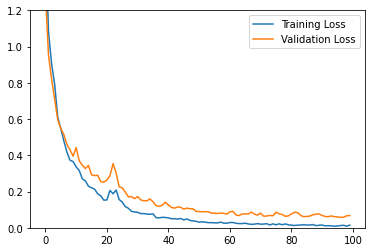

Prediction time HH:MM:SS =  0:00:00
Prediction accuracy: 0.962
Pass number  2  of  20
Number filters = 50
INFO:tensorflow:Assets written to: my_1D_CNN_model/assets
Training time HH:MM:SS =  0:00:04
sklearn train_test_split(X, y, test_size=0.25, random_state=42, stratify=y) 
Validation Accuracy: 0.986


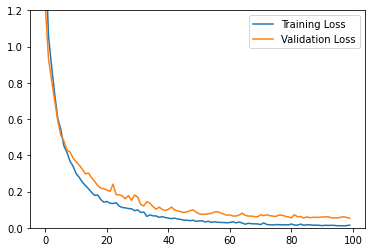

Prediction time HH:MM:SS =  0:00:00
Prediction accuracy: 0.976
Pass number  3  of  20
Number filters = 50
INFO:tensorflow:Assets written to: my_1D_CNN_model/assets
Training time HH:MM:SS =  0:00:04
sklearn train_test_split(X, y, test_size=0.25, random_state=42, stratify=y) 
Validation Accuracy: 0.981


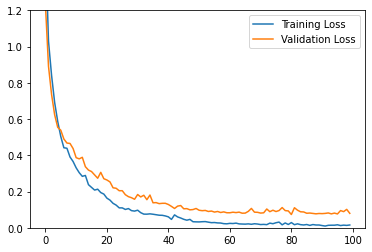

Prediction time HH:MM:SS =  0:00:00
Prediction accuracy: 0.967
Pass number  4  of  20
Number filters = 50
INFO:tensorflow:Assets written to: my_1D_CNN_model/assets
Training time HH:MM:SS =  0:00:04
sklearn train_test_split(X, y, test_size=0.25, random_state=42, stratify=y) 
Validation Accuracy: 0.981


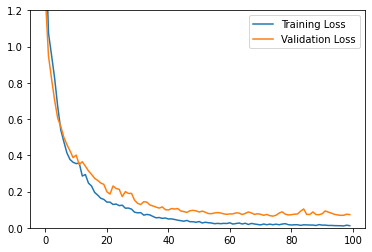

Prediction time HH:MM:SS =  0:00:00
Prediction accuracy: 0.971
Pass number  5  of  20
Number filters = 50
INFO:tensorflow:Assets written to: my_1D_CNN_model/assets
Training time HH:MM:SS =  0:00:04
sklearn train_test_split(X, y, test_size=0.25, random_state=42, stratify=y) 
Validation Accuracy: 0.981


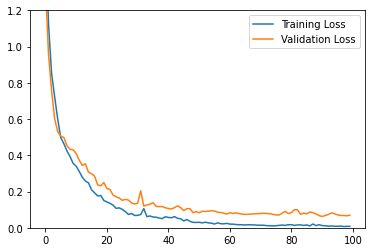

Prediction time HH:MM:SS =  0:00:00
Prediction accuracy: 0.971
Pass number  6  of  20
Number filters = 50
INFO:tensorflow:Assets written to: my_1D_CNN_model/assets
Training time HH:MM:SS =  0:00:04
sklearn train_test_split(X, y, test_size=0.25, random_state=42, stratify=y) 
Validation Accuracy: 0.981


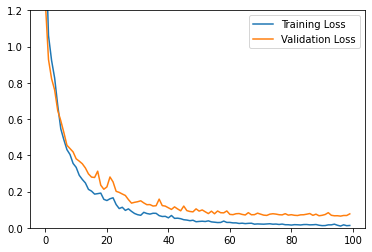

Prediction time HH:MM:SS =  0:00:00
Prediction accuracy: 0.971
Pass number  7  of  20
Number filters = 50
INFO:tensorflow:Assets written to: my_1D_CNN_model/assets
Training time HH:MM:SS =  0:00:04
sklearn train_test_split(X, y, test_size=0.25, random_state=42, stratify=y) 
Validation Accuracy: 0.986


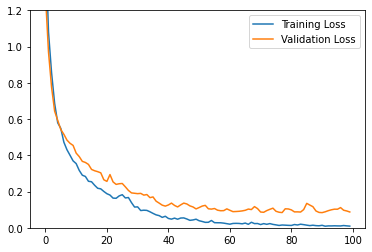

Prediction time HH:MM:SS =  0:00:00
Prediction accuracy: 0.971
Pass number  8  of  20
Number filters = 50
INFO:tensorflow:Assets written to: my_1D_CNN_model/assets
Training time HH:MM:SS =  0:00:04
sklearn train_test_split(X, y, test_size=0.25, random_state=42, stratify=y) 
Validation Accuracy: 0.986


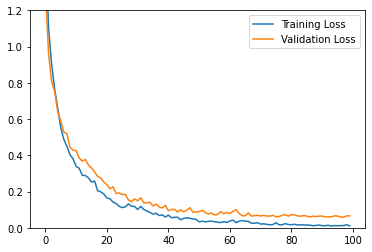

Prediction time HH:MM:SS =  0:00:00
Prediction accuracy: 0.971
Pass number  9  of  20
Number filters = 50
INFO:tensorflow:Assets written to: my_1D_CNN_model/assets
Training time HH:MM:SS =  0:00:04
sklearn train_test_split(X, y, test_size=0.25, random_state=42, stratify=y) 
Validation Accuracy: 0.981


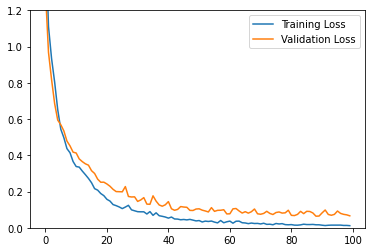

Prediction time HH:MM:SS =  0:00:00
Prediction accuracy: 0.967
Pass number  10  of  20
Number filters = 50
INFO:tensorflow:Assets written to: my_1D_CNN_model/assets
Training time HH:MM:SS =  0:00:04
sklearn train_test_split(X, y, test_size=0.25, random_state=42, stratify=y) 
Validation Accuracy: 0.986


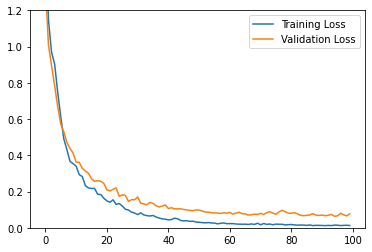

Prediction time HH:MM:SS =  0:00:00
Prediction accuracy: 0.976
Pass number  11  of  20
Number filters = 50
INFO:tensorflow:Assets written to: my_1D_CNN_model/assets
Training time HH:MM:SS =  0:00:04
sklearn train_test_split(X, y, test_size=0.25, random_state=42, stratify=y) 
Validation Accuracy: 0.976


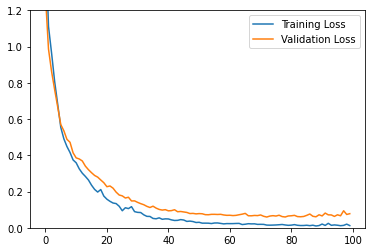

Prediction time HH:MM:SS =  0:00:00
Prediction accuracy: 0.967
Pass number  12  of  20
Number filters = 50
INFO:tensorflow:Assets written to: my_1D_CNN_model/assets
Training time HH:MM:SS =  0:00:04
sklearn train_test_split(X, y, test_size=0.25, random_state=42, stratify=y) 
Validation Accuracy: 0.976


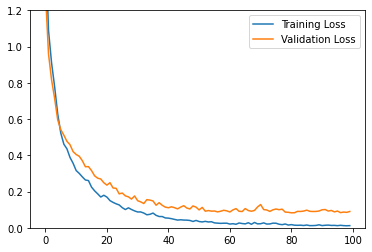

Prediction time HH:MM:SS =  0:00:00
Prediction accuracy: 0.962
Pass number  13  of  20
Number filters = 50
INFO:tensorflow:Assets written to: my_1D_CNN_model/assets
Training time HH:MM:SS =  0:00:04
sklearn train_test_split(X, y, test_size=0.25, random_state=42, stratify=y) 
Validation Accuracy: 0.986


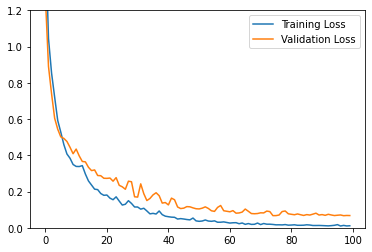

Prediction time HH:MM:SS =  0:00:00
Prediction accuracy: 0.962
Pass number  14  of  20
Number filters = 50
INFO:tensorflow:Assets written to: my_1D_CNN_model/assets
Training time HH:MM:SS =  0:00:04
sklearn train_test_split(X, y, test_size=0.25, random_state=42, stratify=y) 
Validation Accuracy: 0.986


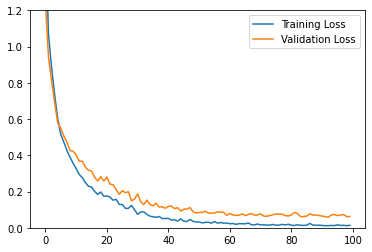

Prediction time HH:MM:SS =  0:00:00
Prediction accuracy: 0.971
Pass number  15  of  20
Number filters = 50
INFO:tensorflow:Assets written to: my_1D_CNN_model/assets
Training time HH:MM:SS =  0:00:04
sklearn train_test_split(X, y, test_size=0.25, random_state=42, stratify=y) 
Validation Accuracy: 0.971


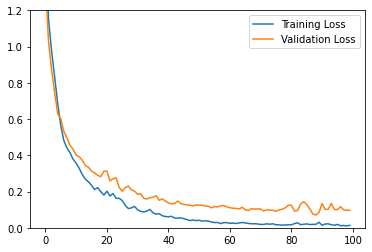

Prediction time HH:MM:SS =  0:00:00
Prediction accuracy: 0.967
Pass number  16  of  20
Number filters = 50
INFO:tensorflow:Assets written to: my_1D_CNN_model/assets
Training time HH:MM:SS =  0:00:03
sklearn train_test_split(X, y, test_size=0.25, random_state=42, stratify=y) 
Validation Accuracy: 0.986


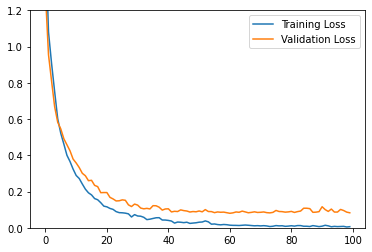

Prediction time HH:MM:SS =  0:00:00
Prediction accuracy: 0.971
Pass number  17  of  20
Number filters = 50
INFO:tensorflow:Assets written to: my_1D_CNN_model/assets
Training time HH:MM:SS =  0:00:04
sklearn train_test_split(X, y, test_size=0.25, random_state=42, stratify=y) 
Validation Accuracy: 0.976


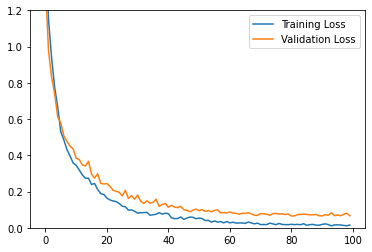

Prediction time HH:MM:SS =  0:00:00
Prediction accuracy: 0.971
Pass number  18  of  20
Number filters = 50
INFO:tensorflow:Assets written to: my_1D_CNN_model/assets
Training time HH:MM:SS =  0:00:04
sklearn train_test_split(X, y, test_size=0.25, random_state=42, stratify=y) 
Validation Accuracy: 0.981


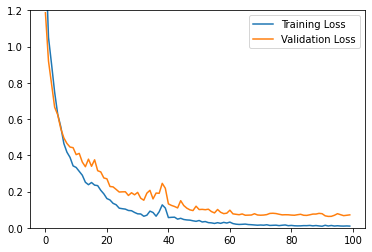

Prediction time HH:MM:SS =  0:00:00
Prediction accuracy: 0.967
Pass number  19  of  20
Number filters = 50
INFO:tensorflow:Assets written to: my_1D_CNN_model/assets
Training time HH:MM:SS =  0:00:04
sklearn train_test_split(X, y, test_size=0.25, random_state=42, stratify=y) 
Validation Accuracy: 0.981


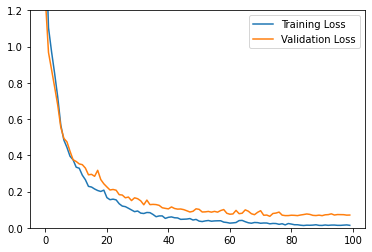

Prediction time HH:MM:SS =  0:00:00
Prediction accuracy: 0.976
Pass number  20  of  20
Number filters = 50
INFO:tensorflow:Assets written to: my_1D_CNN_model/assets
Training time HH:MM:SS =  0:00:06
sklearn train_test_split(X, y, test_size=0.25, random_state=42, stratify=y) 
Validation Accuracy: 0.981


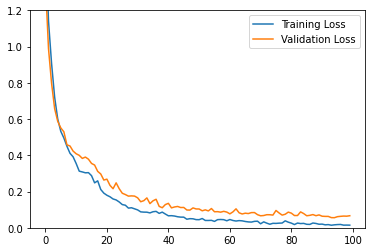

Prediction time HH:MM:SS =  0:00:00
Prediction accuracy: 0.976
Training time,0:00:06,0:00:04,0:00:04,0:00:04,0:00:04,0:00:04,0:00:04,0:00:04,0:00:04,0:00:04,0:00:04,0:00:04,0:00:04,0:00:04,0:00:04,0:00:03,0:00:04,0:00:04,0:00:04,0:00:06
 Validation accuracy,0.990,0.986,0.981,0.981,0.981,0.981,0.986,0.986,0.981,0.986,0.976,0.976,0.986,0.986,0.971,0.986,0.976,0.981,0.981,0.981,Avg = ,0.982
 Prediction time,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00
 Prediction accuracy,0.962,0.976,0.967,0.971,0.971,0.971,0.971,0.971,0.967,0.976,0.967,0.962,0.962,0.971,0.967,0.971,0.971,0.967,0.976,0.976,Avg = ,0.970

              precision    recall  f1-score   support

  Downstairs       0.94      0.97      0.96        34
     Jogging       1.00      0.94      0.97        35
     Sitting       1.00      1.00      1.00        36
    Standing       1.00      1.00      1.00        34
    Up

In [12]:
#Training Params
BATCH_SIZE = 32
#epochs and kernel size (typ 1s) are set above right after DATABASE is selected
log_full_fname = start_logfiles(base_name=DATASET+'_Stratify',
                                first_line='Stratification' + DATASET)

pass_info = "--- batch_size = " + str(BATCH_SIZE)
pass_info += " kernel_size = " + str(kernel_size)
pass_info += " num_epochs = " + str(NUM_EPOCHS) + "\n"
print (pass_info)
with open(log_full_fname, "a") as file_object:
    file_object.write(log_info)
    file_object.write(pass_info)
repeats = 10;
#for my_split in my_full_list:
for i in range(1):
    for repeat_num in range(repeats):  #rerun current config
        print("Pass number ", repeat_num + 1, " of ",repeats)
        if False: #set to True to evaluate # filter impact (little if > 15)
            num_filters = 5*(repeat_num + 1)
        else:
            num_filters = 50
        print("Number filters =",num_filters)
        start_time = time.time()
        history = evaluate_model(X_train, y_train, X_validation, y_validation,
                                 BATCH_SIZE, NUM_EPOCHS, my_filters = num_filters,
                                 my_kernel_size = kernel_size)
        end_time = time.time()
        training_time = str(timedelta(seconds=(end_time - start_time))).split('.', 2)[0]
        print('Training time HH:MM:SS = ',training_time)
        print(method, "\nValidation Accuracy: %0.3f" % history.history['val_accuracy'][-1])
        #Plot the training and validation loss
        fig = plt.figure()
        plt.plot(history.history["loss"], label="Training Loss")
        plt.plot(history.history["val_loss"], label="Validation Loss")
        plt.legend()
        plt.ylim([0,1.2]) #set limit - 1.2 has been a good value experimentally
        plt.show()
        #Now run trained model against test set
        start_time = time.time()
        #Need to sort this out - returned arrays are re-encoded, but error
        acc, y_pred = run_model(X_test, y_test)
        #acc = run_model(X_test, y_test)
        end_time = time.time()
        predict_time = str(timedelta(seconds = (end_time - start_time))).split('.', 2)[0]
        print('Prediction time HH:MM:SS = ',predict_time)
        print('Prediction accuracy: {0:.3f}'.format(acc))
        #col_sep = '&' # for import as LaTeX table
        #end_line = '\\\\ \\hline\n' # end of table row with underline for latex
        col_sep = ',' # for csv
        end_line = '\n' # for csv
        if (repeat_num == 0):
            train_time = 'Training time'+ col_sep + training_time
            val_acc = 'Validation accuracy'+ col_sep +'%0.3f' % history.history['val_accuracy'][-1]
            cumm_val_acc = history.history['val_accuracy'][-1]
            pred_time = 'Prediction time' + col_sep + predict_time
            pred_acc = 'Prediction accuracy' + col_sep + '{0:.3f}'.format(acc)
            cumm_run_acc = acc #total acc for quick avg calc
        else:
            train_time += col_sep + training_time
            val_acc += col_sep + '%0.3f' % history.history['val_accuracy'][-1]
            cumm_val_acc += history.history['val_accuracy'][-1]
            pred_time += col_sep + predict_time
            pred_acc += col_sep + '{0:.3f}'.format(acc)
            cumm_run_acc += acc
    train_time += end_line
    val_acc += col_sep + "Avg = " + col_sep + '{0:.3f}'.format(cumm_val_acc/repeats)+ end_line
    pred_time += end_line
    pred_acc += col_sep + "Avg = " + col_sep + '{0:.3f}'.format(cumm_run_acc/repeats)+ end_line
    print (train_time, val_acc, pred_time, pred_acc)
    # note this prints the classification report for the last run, not all repeats
    y_test_act = np.argmax(y_test, axis=-1) #undo one-hot encoding
    c_rpt = classification_report(y_test_act, y_pred, target_names=t_names)
    print (c_rpt)
    with open(log_full_fname, "a") as file_object:
            file_object.write(train_time)
            file_object.write(val_acc)
            file_object.write(pred_time)
            file_object.write(pred_acc)
            file_object.write(c_rpt)
#save the last loss plot as pdf
full_fig_fname = log_full_fname.split('.')[0] + '_loss.pdf'
print("saving loss plot as",full_fig_fname)
fig.savefig(full_fig_fname,format='pdf')

# Show Confusion Matrix

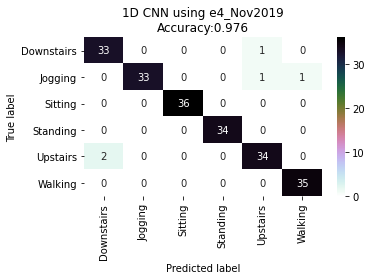

In [13]:
cm = confusion_matrix(y_test_act, y_pred)
cm_df = pd.DataFrame(cm,
                     index = t_names, 
                     columns = t_names)
fig = plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='cubehelix_r')
plt.title('1D CNN using '+DATASET+'\nAccuracy:{0:.3f}'.format(accuracy_score(y_test_act, y_pred)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout() # keeps labels from being cutoff when saving as pdf
plt.show()

In [12]:
#save the confusion matrix figure as pdf
full_fig_fname = log_full_fname.split('.')[0] + '_cm.pdf'
print("saving cm plot as",full_fig_fname)
fig.savefig(full_fig_fname,format='pdf')

saving cm plot as /content/drive/My Drive/Colab_Run_Results/e4_Nov2019_Stratify_Jun-22-2021_1555_cm.pdf


In [ ]:
#save the model summary and model plot
model = keras.models.load_model('my_1D_CNN_model')
my_model = model.summary()
full_model_fname = log_full_fname.split('.')[0] + '_model.txt'
with open(full_model_fname, "a") as file_object:
    model.summary(print_fn=lambda x: file_object.write(x + '\n'))
    #acknowledgement https://stackoverflow.com/users/14951382/sparklingdew
#plot using keras function
#ref https://keras.io/api/utils/model_plotting_utils/
full_mplot_fname = log_full_fname.split('.')[0] + '_model.png'
tf.keras.utils.plot_model(model, to_file=full_mplot_fname, show_shapes=True)

# CELLS BELOW NEED UPDATES - Evaluate and store text based results

In [ ]:
#The output of this cell is all text so it can be captured.
#run next cell to see the results and save the txt file
#on the screen and saved in a log file using current time stamp.
#%%capture --no-display results_txt
print ("1D CNN with",DATASET)
#print(notes)
print(get_shapes([X_train, y_train, X_validation, y_validation, X_test, y_test]))
print("Batch size =",BATCH_SIZE,"Number Epochs =",NUM_EPOCHS)
model = keras.models.load_model('my_1D_CNN_model')
print (model.summary())
#print('Training time   =',(np.str(train_time).split(".")[0]), 'HH:MM:SS')
#print('Evaluation time =',(np.str(eval_time).split(".")[0]), 'HH:MM:SS')
#print("Using CPU only")#,gpu_info[1])
print(classification_report(y_test, y_pred, target_names=ACT))
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix")
print(cm)

In [ ]:
#display stored output of previous cell (need linux tee function...)
print(results_txt)

In [ ]:
#build log filename and store results
result_dir = '/content/drive/My Drive/Colab_Run_Results'
timestamp = time.strftime('%b-%d-%Y_%H%M', time.localtime())
acc_str = '{:.0f}'.format(accuracy_score(y_test, y_pred)*100)
log_fname = '1D_CNN_'+DATASET+'_'+acc_str+'_'+timestamp
full_fname = result_dir+'/'+log_fname+'.txt'
print("Saving text log",full_fname)
with open(full_fname, "w") as text_file:
    print(results_txt, file=text_file)
pred_fname = result_dir+'/'+log_fname+'.csv'  
#convert to pandas for labeling columns in csv
print("Saving test and predictions as ",pred_fname)
df_predictions = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})
df_predictions.to_csv(pred_fname)

In [ ]:
cm_df = pd.DataFrame(cm,
                     index = ACT, 
                     columns = ACT)
fig = plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='cubehelix_r')
plt.title('1D CNN w/'+DATASET+'\nAccuracy:{0:.3f}'.format(accuracy_score(y_test, y_pred)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
#save the figure - makes both png and pdf versions
full_fname = result_dir+'/'+log_fname+'.png'
print("saving cm plot as",full_fname)
fig.savefig(full_fname)
full_fname = result_dir+'/'+log_fname+'.pdf'
print("saving cm plot as",full_fname)
fig.savefig(full_fname,format='pdf')